In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib as mpl
from tensorflow.keras.saving import load_model
import numpy as np
import cv2


In [41]:
model = keras.models.load_model("model_1.keras")
img_path = "KaggleDataset/test/PNEUMONIA/person1_virus_8.jpeg"
img = tf.keras.utils.load_img(img_path, target_size=(224,224)) #preprocessing the img so that it match with the AI input

def preprocess_input(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0) #it will put the img (1,224,244,3) = (1, heights,width,channels), the number one means the number of batch
    return img_array


In [42]:
prediction = model.predict(preprocess_input(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


In [43]:
print(np.round(prediction))

[[0. 0. 1. 0.]]


In [30]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 conv2d_12
1 conv2d_13
2 batch_normalization_8
3 max_pooling2d_10
4 conv2d_14
5 max_pooling2d_11
6 last_conv
7 batch_normalization_9
8 max_pooling2d_12
9 global_average_pooling2d_4
10 dense_4
11 dropout_4
12 Predictions


In [31]:
# New symbolic input
input_tensor = keras.Input(shape=(224, 224, 3))

# tracking last_conv output
x = input_tensor
last_conv_output = None

for layer in model.layers:
    x = layer(x)
    if layer.name == "last_conv":
        last_conv_output = x

predictions = x  # this is the output of the last Dense layer

In [23]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 112, 112, 100)       │          57,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 56, 56, 128)         │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Predictions (Dense)                  │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,050 (1.60 MB)

 Trainable params: 209,832 (819.66 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 209,834 (819.67 KB)

In [ ]:
class_names = {0: "COVID19", 1: "NORMAL", 2: "PNEUMONIA", 3: "TUBERCULOSIS"}

def get_img_array(img_path, size=(224,224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = array / 255.0
    array = np.expand_dims(array, axis=0)
    return array

    
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.Model(
    inputs=input_tensor, outputs = [last_conv_output, predictions] #give out a grad and prediction probs
)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    grads = tape.gradient(class_channel, last_conv_layer_output)[0]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

   #normalize the heatmap 0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds.numpy()[0]

In [25]:
def save_and_display_gradcam(img_path, model, last_conv_layer_name="last_conv"):
    #img array
    img_array = get_img_array(img_path, size=(224,224))
    
    # Load the original image
    img = keras.utils.load_img(img_path, target_size=(224,224))
    img = keras.utils.img_to_array(img).astype("uint8")

    # Rescale heatmap to a range 0-255
    heatmap, preds = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Predicted class + probability
    pred_idx = int(np.argmax(preds))
    pred_name = class_names.get(pred_idx, "Unknown")
    pred_prob = float(preds[pred_idx]) * 100

    # colormap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized),
        cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    #show
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"{pred_name} ({pred_prob:.1f}%)")
    plt.show()



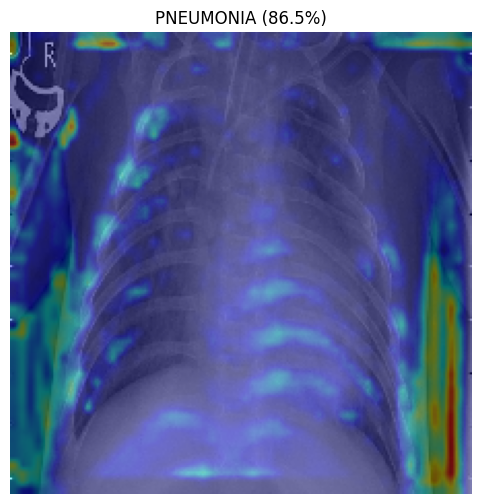

In [44]:
save_and_display_gradcam(img_path, model,last_conv_layer_name="last_conv")